In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import neighbors
from matplotlib import pyplot as plt


notebook_lifesat_url0 = 'https://github.com/gawron/python-for-social-science/blob/master/pandas/datasets/lifesat/'
lifesat_url = notebook_lifesat_url0.replace('github', 'raw.githubusercontent')
lifesat_url = lifesat_url.replace('blob/','')

def load_lifesat_data (lifesat_url):
    oecd_file = 'oecd_bli_2015.csv'
    oecd_url= f'{lifesat_url}{oecd_file}'
    return pd.read_csv(oecd_url, thousands=',',encoding='utf-8')



#backup = oecd_bli, gdp_per_capita
# Downloaded data from http://goo.gl/j1MSKe (=> imf.org) to github
def load_gdp_data ():
    gdp_file = "gdp_per_capita.csv"
    gdp_url = f'{lifesat_url}{gdp_file}'
    return pd.read_csv(gdp_url, thousands=',', delimiter='\t',
                                 encoding='latin1', na_values="n/a")
    

def prepare_country_stats(oecd_bli):
    """
    This would normally do prep work,including the train/test split.
    For now just redoing the steps whereby we merged gdp info with
    the original life-satisfaction data. and split training and test
    """
    oecd_bli = load_lifesat_data(lifesat_url)
    print(len(oecd_bli))
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    print(len(oecd_bli))
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita = load_gdp_data()
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    # Make "Country" the index column.  We are going to merge data on this column.
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita, 
                                   left_index=True, right_index=True)
    #raise Exception
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    return full_country_stats

def split_full_country_stats (full_country_stats):
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))

    #Train on this!
    training_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]
    #Test on this!
    test_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[remove_indices]
    return training_data, test_data


In [2]:

# Prepare the data
oecd_bli = load_lifesat_data(lifesat_url)
full_country_stats = prepare_country_stats(oecd_bli)
training_data,test_data = split_full_country_stats(full_country_stats)

# The np.c_ makes both X and y  2D arrays
X_train = np.c_[training_data["GDP per capita"]]
X_test = np.c_[test_data["GDP per capita"]]

y_train = np.c_[training_data["Life satisfaction"]]
y_test = np.c_[test_data["Life satisfaction"]]

3292
888


#### Training and evaluation

The following demonstrates in principle how to build a regressor that uses
an instance of the  scikit learn `Pipeline` class, which was first demonstrated
in the polynomial regression example earlier in this NB.

The example is trivial since scaling the data has no effect on regression 
with one independent variable,  but the code model is solid, and will
extend easily to more complicated (and more useful) pipelines.

In [24]:
y_train.shape

(29, 1)

Lin Training R2: 0.73
KNN Training R2: 0.91


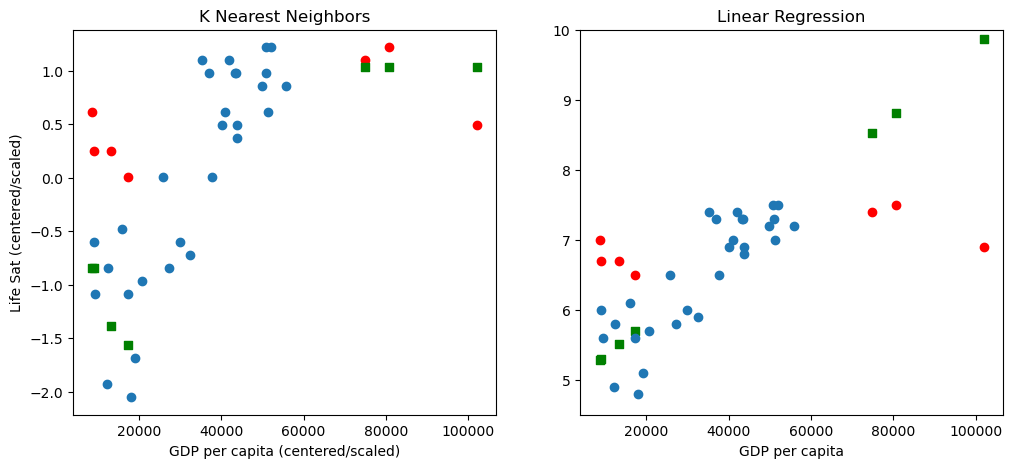

In [32]:
#######################################################################
#
#   Training
#
########################################################################

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import pipeline


##  Create the linear model pipeline
scaler2 = preprocessing.StandardScaler()
# select and train a linear regression model 
lin_reg2 = linear_model.LinearRegression()
pipeline_reg3 = pipeline.Pipeline([('scal', scaler2), ('lin', lin_reg2)])

##  Create the KNN model pipeline
# Select and train a k-neighbors regression model, supplying values for important parameters
knn_reg_model = neighbors.KNeighborsRegressor(n_neighbors=2)
scaler3 = preprocessing.StandardScaler()
knn_pipeline = pipeline.Pipeline([('scal', scaler3), ('knn', knn_reg_model)])



# select and train a linear regression model
pipeline_reg3.fit(X_train, y_train)
print(f"Lin Training R2: {pipeline_reg3.score(X_train, y_train):.2f}")

# Train the model (always the .fit() method in sklearn, even with a pipeline)
# Unlike the usual version of scaling, for KNN regression we scale X_train and Y_train together
points = np.concatenate([X_train,y_train],axis=1)
scaler5 = preprocessing.StandardScaler()
points_s = scaler5.fit_transform(points)
X_train_s,y_train_s = points_s[:,0:1],points_s[:,1:2]
knn_pipeline.fit(X_train_s, y_train_s)
print(f"KNN Training R2: {knn_pipeline.score(X_train_s, y_train_s):.2f}")

# Train the model
#######################################################################
#
#   Testing
#
########################################################################

# Use models to predict y vals on test data.
#Yp = knn_reg_model.predict(X_test)  # Not using a pipeline
t_points = np.concatenate([X_test,y_test],axis=1)
t_points_s = scaler5.transform(t_points)
X_test_s,y_test_s = t_points_s[:,0:1],t_points_s[:,1:2]
Yp = knn_pipeline.predict(X_test_s)

#Yp3 = lin_reg_model3.predict(X_test)  # Not using a pipeline
Yp3 = pipeline_reg3.predict(X_test)

#######################################################################
#
#   Plotting
#
########################################################################

# Set up a figure 
f = plt.figure(figsize=(12,5))
#  Add 2 plots side by side
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

#######################################
# Model 1 plot
#######################################
# Put test points in plot, color red
#ax.scatter(Xm, Ym, c="r",marker="o")
ax.scatter(X_test_s, y_test_s, c="r",marker="o")
# Put  predicted test points in plot color grren
#ax.scatter(Xm, Yp, c="g",marker="s")
ax.scatter(X_test_s, Yp, c="g",marker="s")
# Put training data in plot; let matplotlib choose the color.
# It will choose a color not yet used in this axis.
ax.scatter(X_train_s,y_train_s)
# plot parameters
#ax.set_ylim([4.5,10])
ax.set_title('K Nearest Neighbors')
ax.set_xlabel('GDP per capita (centered/scaled)')
ax.set_ylabel('Life Sat (centered/scaled)')

#######################################
# Model 2 plot
#######################################
#ax2.scatter(Xm, Ym, c="r",marker="o")
ax2.scatter(X_test, y_test, c="r",marker="o")
#ax2.scatter(Xm, Yp3, c="g",marker="s")
ax2.scatter(X_test, Yp3, c="g",marker="s")
ax2.scatter(X_train, y_train)
# plot parameters
ax2.set_ylim([4.5,10])
ax2.set_xlabel('GDP per capita')
ax2.set_title('Linear Regression')

# Not usually needed in a NB but okay
plt.show()
########################################################################

#oecd_bli, gdp_per_capita = backup


The blue points are the training data and the red points are the test data.
The green points are the predicted locations of the red points (using the GDP, the x-value, to predict the Life Satisfaction, the y-value).  Comparing the red points with the blue training data points, we see the test points are distinct outliers.   

In the linear regression graph, as expected, the green points lie on a line chosen based on the blue points, the training data.  Because the data does not lie on a line, the linear model ends up having two flaws.  It underestimates the life satisfaction of poor folks in the test set, and overestimates that of rich folks. 

The predicted K Nearest Neighbor points do **not** lie on a line.  This is because
the K Nearest Neighbor regressor is **not** a linear model.  It is a is a more powerful, more flexible model and does a better job predicting here, in the sense that there is less spread between the red and green points. This is also seen in the improved training R2 score; more accuracy has been achieved in fitting the training data.   Despite the fact that the training data lacks high GDP countries, the K Nearest Neighbor model seems to capture the fact that life satisfaction levels off with GDPs above 60K.  

The KNN regressor is a very simple idea.  Training is trivial: store the training set in the model.
At test time when predicting the regression value for $x$ find the the k nearest training points
to x and average their values, possibly weighting their contribution by their distance from $x$. In a 2Dplane,
the predicted values do not lie on a line (as can be seen in the plot), but they do  lie on the line segments
found in what's called the Voronoi diagram of the data, which in our case, looks a bit like this,
with the orange vertices showing possible predicted values.  For example, the vertex at about (-1.7,-.8)
would be the value predicted for a test point whose three nearest neighbors were the three blue training points closest to that vertex.

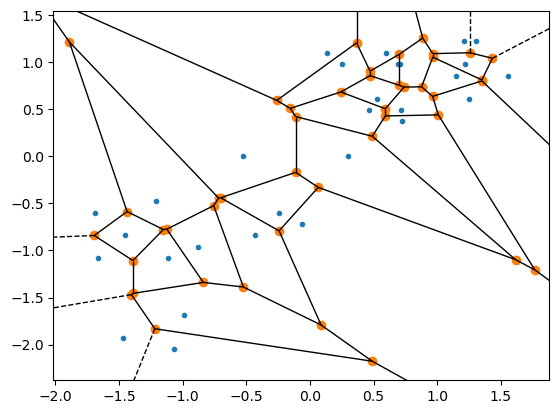

In [27]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

points = np.concatenate([X_train,y_train],axis=1)
# Need to scale X_train and y_train together to make the diagram look at all comprehensible
scaler4 = preprocessing.StandardScaler()
points_s = scaler4.fit_transform(points)
vor = Voronoi(points_s)
fig = voronoi_plot_2d(vor)
plt.show()